In [78]:
import geopandas as gpd
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import cartopy.crs as ccrs
import matplotlib.ticker as mticker


#segoe ui
plt.rcParams['font.family'] = 'Segoe UI'

#### Import bias corrected pickled data

In [154]:
src_isimip = r"D:\VUB\_data\_isimip_3b\bias_corrected"
be_shp = gpd.read_file(r"W:\VUB\_main_research\data\shapefiles\world_countries\10m_cultural\10m_cultural\be_joined_4326.shp")

src_EOBS = r'D:/VUB/_data/mHM_EOBS'
pr_EOBS = xr.open_dataset(f'{src_EOBS}/pre.nc')
tmax_EOBS = xr.open_dataset(f'{src_EOBS}/tmax.nc')
tmin_EOBS = xr.open_dataset(f'{src_EOBS}/tmin.nc')


#changes in temperature and precipitation per scenario
models = list(map(str.upper, ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll']))
vars = ['pre', 'tasmax', 'tasmin', 'tavg']
scenarios = ['historical', 'ssp370', 'ssp585']


isimip_data = {}

#Open the datasets for each model and scenario
for model in models:
    for scenario in scenarios:
        for variable in vars:
            file_path = f"{src_isimip}/{model}/{scenario}/{model}_{variable}_highres.nc"
            data = xr.open_dataset(file_path)
            name = f"{model}_{scenario}_{variable}"
            isimip_data[name] = data

#### Functions (to transfer)

In [155]:
#clip to region
from shapely.geometry import mapping
def clip_to_region(shapefile, xr_dataset):
    """
    This function clips an xarray dataset to a given shapefile.

    Parameters
    ----------
    shapefile : geopandas.GeoDataFrame
        The shapefile to clip the dataset to.
    xr_dataset : xarray.Dataset
        The dataset to clip.

    Returns
    -------
    xarray.Dataset
        The clipped dataset.
    """
        #set shapefile to crs 4326
    shapefile = shapefile.to_crs('epsg:4326')

    #drop bnds dimension
    xr_dataset = xr_dataset.drop_dims("bnds", errors="ignore")

    #set spatial dimensions
    xr_dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)

    #write crs
    xr_dataset.rio.write_crs('epsg:4326', inplace=True)

    #clip
    clipped = xr_dataset.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs, drop=True)

    return clipped

#=================================================================

season_order = ['DJF','MAM','JJA','SON']

def seasonal_climatology(da, how, drop_incomplete=True):
    """
    Compute seasonal climatology for meteorological variables.

    Parameters
    ----------
    da : xarray.DataArray
        The data array to compute the seasonal climatology for.
    how : str
        The method to use for aggregation ('sum' or 'mean').
    drop_incomplete : bool
        Whether to drop incomplete seasons (default: True).

    Returns: 
    
    DataArray with dims ('season', lat, lon) ordered DJF,MAM,JJA,SON.
    """
    # 1) monthly aggregation
    if how == 'sum':
        mon = da.resample(time='ME').sum()
    elif how == 'mean':
        mon = da.resample(time='ME').mean()
    else:
        raise ValueError("how must be 'sum' or 'mean'")

    # 2) seasonal aggregation per year (quarters starting in Dec => DJF/MAM/JJA/SON)
    if how == 'sum':
        seas = mon.resample(time='QS-DEC').sum()
    else:  # mean
        seas = mon.resample(time='QS-DEC').mean()

    # 3) (optional) drop incomplete seasons (edge years with <3 months)
    if drop_incomplete:
        nmon = mon.notnull().resample(time='QS-DEC').sum()
        seas = seas.where(nmon >= 3)

    # 4) climatology across years and canonical season order
    clim = seas.groupby('time.season').mean('time')
    return clim.reindex(season=season_order)

def pr_seasonal_delta(fut_da, hist_da, how):
    """
    Seasonal change (future − historical):
      - 'abs' in original units (mm/season if how='sum', °C if how='mean')
      - 'pct' as % change (only meaningful when historical > 0)
    """
    fut  = seasonal_climatology(fut_da,  how=how)
    hist = seasonal_climatology(hist_da, how=how)
    #fut, hist = xr.align(fut, hist, join='exact')  # enforce identical coords

    abs_change = fut - hist
    #pct_change = xr.where(hist > 0, 100.0 * abs_change / hist)
    return abs_change  # or pct_change if you want percentage change


#=================

def plot_seasonal_changes(meteo_dict, ssp_scenario, seasons):

    #subset data for specific SSP scenario
    ssp_dict= {}
    for key in meteo_dict:
        if ssp_scenario in key:
            ssp_dict[key] = meteo_dict[key]

    # extract color scale limits
    v = max(float(np.nanmax(np.abs(da.values))) for da in ssp_dict.values())
    vmin, vmax = -v, v

    # create figure and axes
    fig, axes = plt.subplots(
        nrows=len(ssp_dict), ncols=len(seasons), figsize=(15, 20),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # plot data
    for i, (name, da) in enumerate(ssp_dict.items()):
        model = name.split('_')[0]
        for j, s in enumerate(seasons):
            ax = axes[i, j]
            be_shp.boundary.plot(ax=ax, linewidth=0.5, color='black', transform=ccrs.PlateCarree())
            im = da.sel(season=s).plot(
                ax=ax, cmap='seismic_r', add_colorbar=False,
                vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree()
            )
            if i == 0:
                ax.set_title(s, color='k')
            else:
                ax.set_title('')
            
            # add model label 
            if j == 0: ax.text(-0.05, 0.4, f"{model}", transform=ax.transAxes, ha='center', va='center', rotation=90, weight='bold', fontsize=12)

            gl = ax.gridlines(draw_labels=True, color='gray', lw=0.6, alpha=0.2)
            gl.top_labels = False
            gl.left_labels  = False
            gl.right_labels = (j == len(seasons)-1)
            gl.bottom_labels= (i == len(meteo_dict)-1)
            gl.xlocator = mticker.FixedLocator(np.arange(0, 10, 1))
            gl.ylocator = mticker.FixedLocator(np.arange(49.5, 51.9, 0.4))

        axes[i, 0].set_ylabel(model)  # row label on leftmost plot

    # shared colorbar
    cax = fig.add_axes([0.02, 0.07, 0.95, 0.02]) #left, bottom, width, height
    cb = fig.colorbar(im, cax=cax, orientation='horizontal')
    cb.set_label('Change in Total Seasonal Precipitation (mm)', fontsize=14)

    plt.tight_layout(rect=[0, 0.08, 1, 1])

#### Historical Comparison of EOBS and bias-corrected ISIMIP

In [ ]:
#### compare hist model to hist observed

hist_ISIMIP = {key: da for key, da in isimip_data.items() if 'historical_pre' in key}

#clip to region
hist_ISIMIP_BE = {}

#Clip and subset to overlapping period
hist_EOBS_BE = clip_to_region(be_shp, pr_EOBS.sel(time=slice('1971', '2014')))
seasonal_hist = seasonal_climatology(hist_EOBS_BE, how='sum')

#apply mask
seasonal_hist = seasonal_hist.where(seasonal_hist > 0.0001)

for key, da in hist_ISIMIP.items():
    data = clip_to_region(be_shp, da)
    hist_ISIMIP_BE[key] = data

    #seasonal climatology
    hist_mon_avg = seasonal_climatology(data, how='sum')

     #valid data where var in hist is not 0
    mask = data.where(data.var() > 0.0001).notnull().all(dim='time')
    hist_mon_avg = hist_mon_avg.where(mask)

    hist_ISIMIP_BE[key] = hist_mon_avg

In [116]:
hist_ISIMIP_BE.keys()

dict_keys(['GFDL-ESM4_historical_pre', 'IPSL-CM6A-LR_historical_pre', 'MPI-ESM1-2-HR_historical_pre', 'MRI-ESM2-0_historical_pre', 'UKESM1-0-LL_historical_pre'])

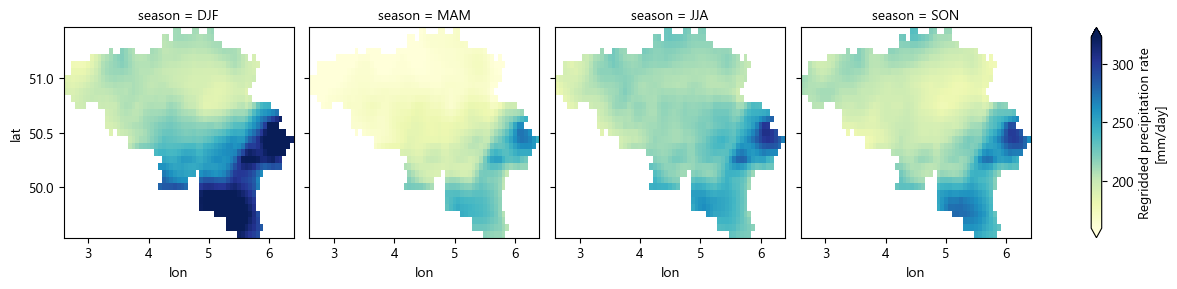

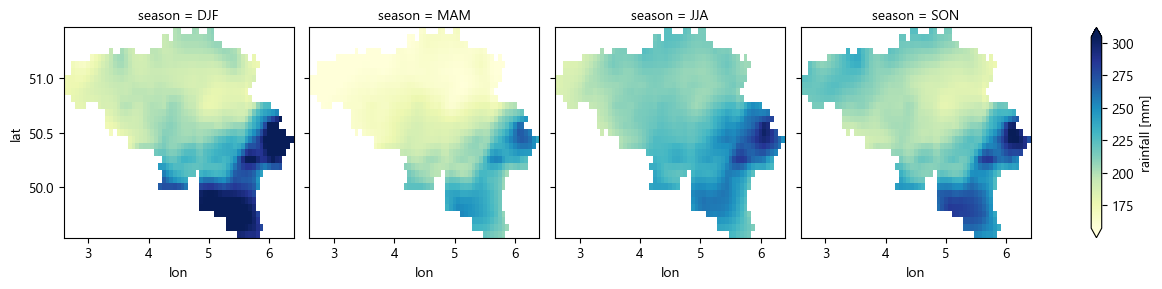

In [152]:
data = hist_ISIMIP_BE['UKESM1-0-LL_historical_pre']

data['pre'].plot(col='season', cmap='YlGnBu', robust=True)

#apply mask
seasonal_hist = seasonal_hist.where(seasonal_hist > 0.0001)
seasonal_hist['pre'].plot(col='season', label='EOBS', cmap='YlGnBu',robust=True)

#### Projected Changes in Precipitation

In [5]:
#changes in temperature and precipitation per scenario
models = list(map(str.upper, ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll']))
var = ['pre', 'tasmax', 'tasmin']
model_scenarios = ['ssp370', 'ssp585']

#-----------------------------------------------------------
#define start and end of historical period
historical_period_start = '1981-01-01'
historical_period_end = '2010-12-31'

#define future period
future_period_start = '2071-01-01'
future_period_end = '2100-12-31'

delta_tmax_isimip_bc_QDM = {}
delta_tmin_isimip_bc_QDM = {}
delta_isimip_pr = {}

seasons = ['DJF', 'MAM', 'JJA', 'SON']

for model in models:
    hist_pr = clip_to_region(
        be_shp,
        isimip_data[f"{model}_historical_pre"].sel(time=slice(historical_period_start, historical_period_end)))['pre']  # <-- ensure DataArray
    
    for scenario in model_scenarios:
        fut_pr = clip_to_region(
            be_shp,
            isimip_data[f"{model}_{scenario}_pre"].sel(time=slice(future_period_start, future_period_end)))['pre']  # <-- ensure DataArray
        

        delta_ds = pr_seasonal_delta(fut_pr, hist_pr, how='sum')  # Dataset with 'abs' and 'pct'

        #valid data where var in 
        mask = hist_pr.isel(time=0).notnull()
        delta_ds = delta_ds.where(mask)

        delta_isimip_pr[f"{model}_{scenario}_delta_pr"] = delta_ds  # or store delta_ds['abs'] if you only want absolute

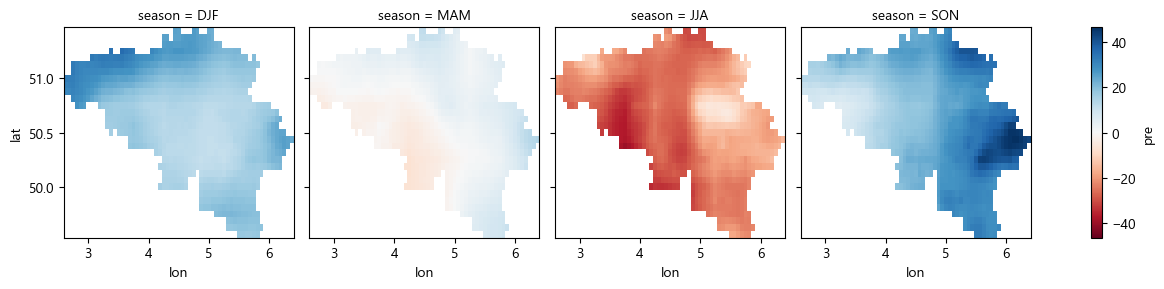

In [6]:
data = delta_isimip_pr['GFDL-ESM4_ssp370_delta_pr']  # Example to access a specific delta dataset

data.plot(col='season', cmap='RdBu', add_colorbar=True)

#### Seasonal Plots per scenario

In [ ]:
#Plot ssp 370
seasons = ['DJF','MAM','JJA','SON']
ssp_scenario= 'ssp370'

plot_seasonal_changes(delta_isimip_pr, ssp_scenario=ssp_scenario, seasons=seasons)

C:\Users\kart\AppData\Local\Temp\ipykernel_22624\1564065764.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 1])


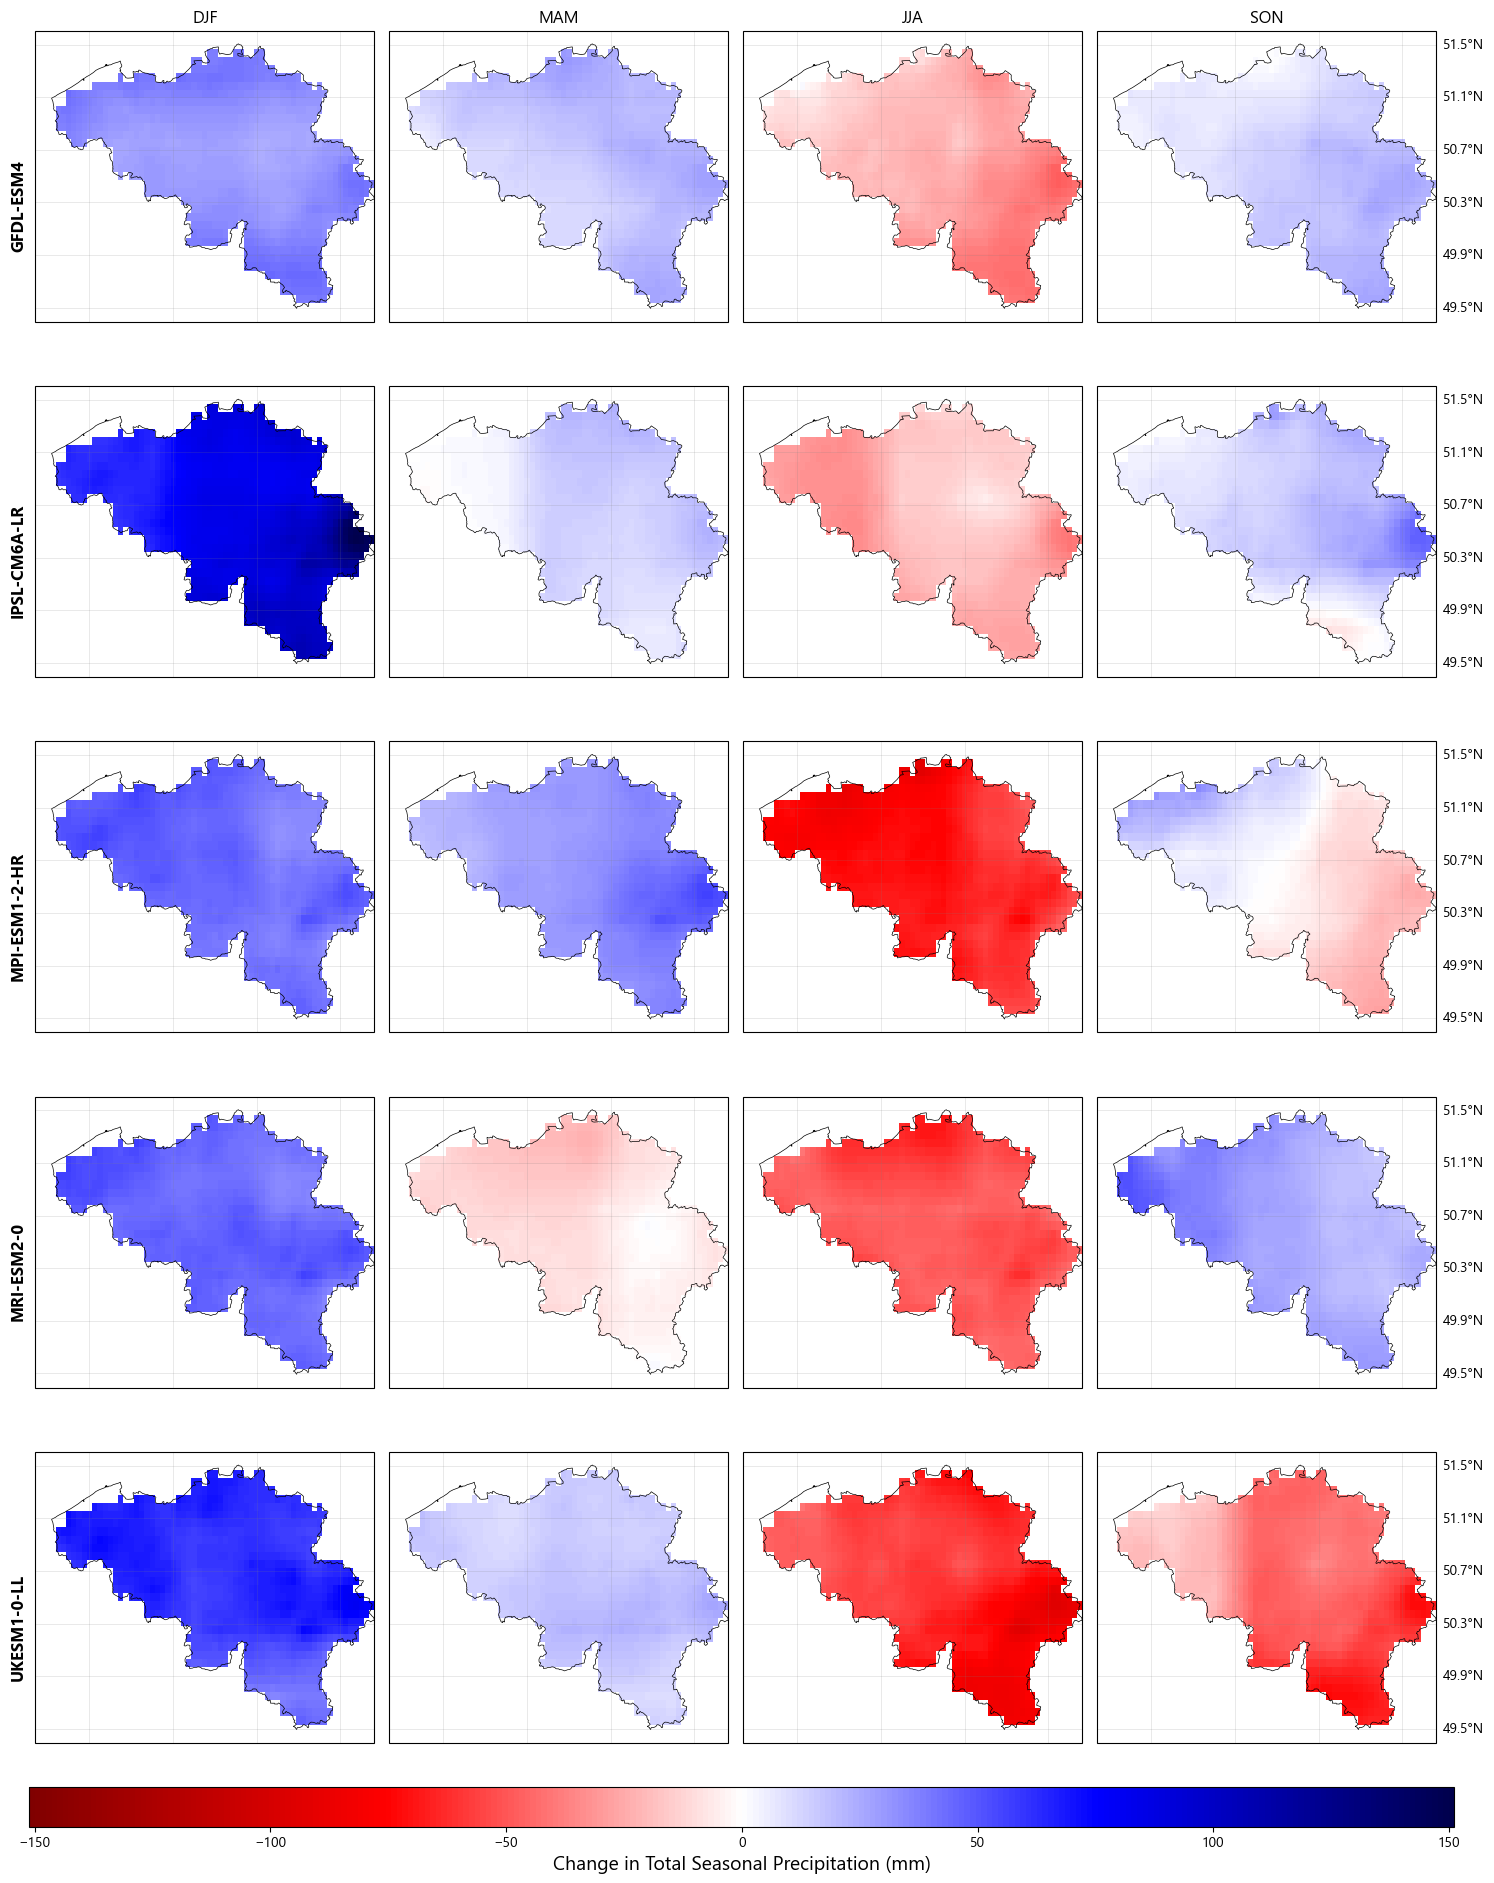

In [199]:
#Plot ssp 585
seasons = ['DJF','MAM','JJA','SON']
ssp_scenario= 'ssp585'

plot_seasonal_changes(delta_isimip_pr, ssp_scenario=ssp_scenario, seasons=seasons)

#### Projected changes in Temperature

In [171]:
t_vars = ['tasmax', 'tasmin', 'tavg']


tas_doy = {}

for model in models:
    for scenario in scenarios:
        for variable in t_vars:
            data = isimip_data.get(f"{model}_{scenario}_{variable}")
            data_BE = clip_to_region(be_shp, data).mean(dim=['lon', 'lat'])
            t_df = data_BE.to_dataframe().drop(columns=['spatial_ref'])
            t_df_doy = t_df.groupby(t_df.index.dayofyear).mean()
            tas_doy[f"{model}_{scenario}_{variable}"] = t_df_doy

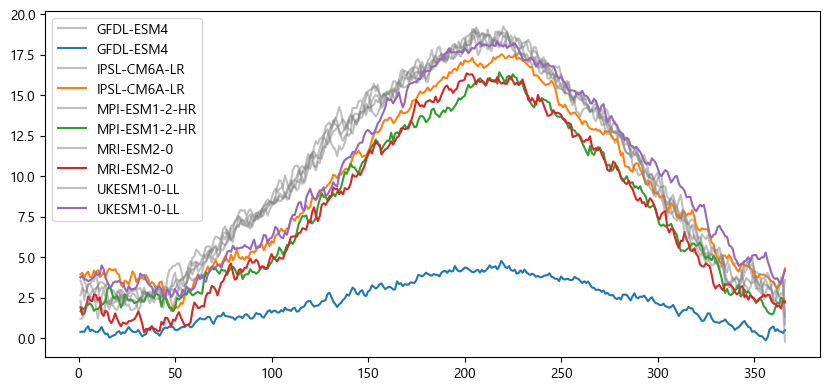

In [198]:
fig, ax = plt.subplots(figsize=(10, 4.5))
for key, df in tas_doy.items():
    if 'ssp585_tasmin' in key:
        plt.plot(df.index, df['tmin'], label=key.split('_')[0], linewidth=1.5)
        plt.legend(loc='upper left', fontsize=10)
    if 'historical_tavg' in key:
        plt.plot(df.index, df['tavg'], label=key.split('_')[0], linewidth=1.5, c='gray', alpha=0.5)
        plt.legend(loc='upper left', fontsize=10)
